In [49]:
from pathlib import Path
import pickle
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import nltk
from nltk.metrics.distance import edit_distance

from morphological_tagging.metrics import RunningStats

EVAL_FILES_PATH = "./morphological_tagging/eval"

model = "UDPipe2"

lang_stats = defaultdict(dict)

In [50]:
eval_data = dict()
eval_stats = dict()
for eval_fp in Path(EVAL_FILES_PATH).glob(f"**/{model}*.pickle"):
    _, lang, _, _, _ = eval_fp.parts[-1].rsplit("_")

    if eval_data.get(lang, True):
        data = []
        with open(eval_fp, "rb") as fr:
            try:
                while True:
                    data.append(pickle.load(fr))
            except EOFError:
                pass

        eval_data[lang] = data[:-1]
        eval_stats[lang] = data[-1]

    else:
        print(f"Language {lang} already processed, skipping.")

In [51]:
langs = sorted(list(eval_data.keys()))
N_langs = len(langs)

In [52]:
langs

['Arabic',
 'Czech',
 'Dutch',
 'English',
 'Finnish',
 'French',
 'Russian',
 'Turkish']

# Lemmatization

## Accuracy

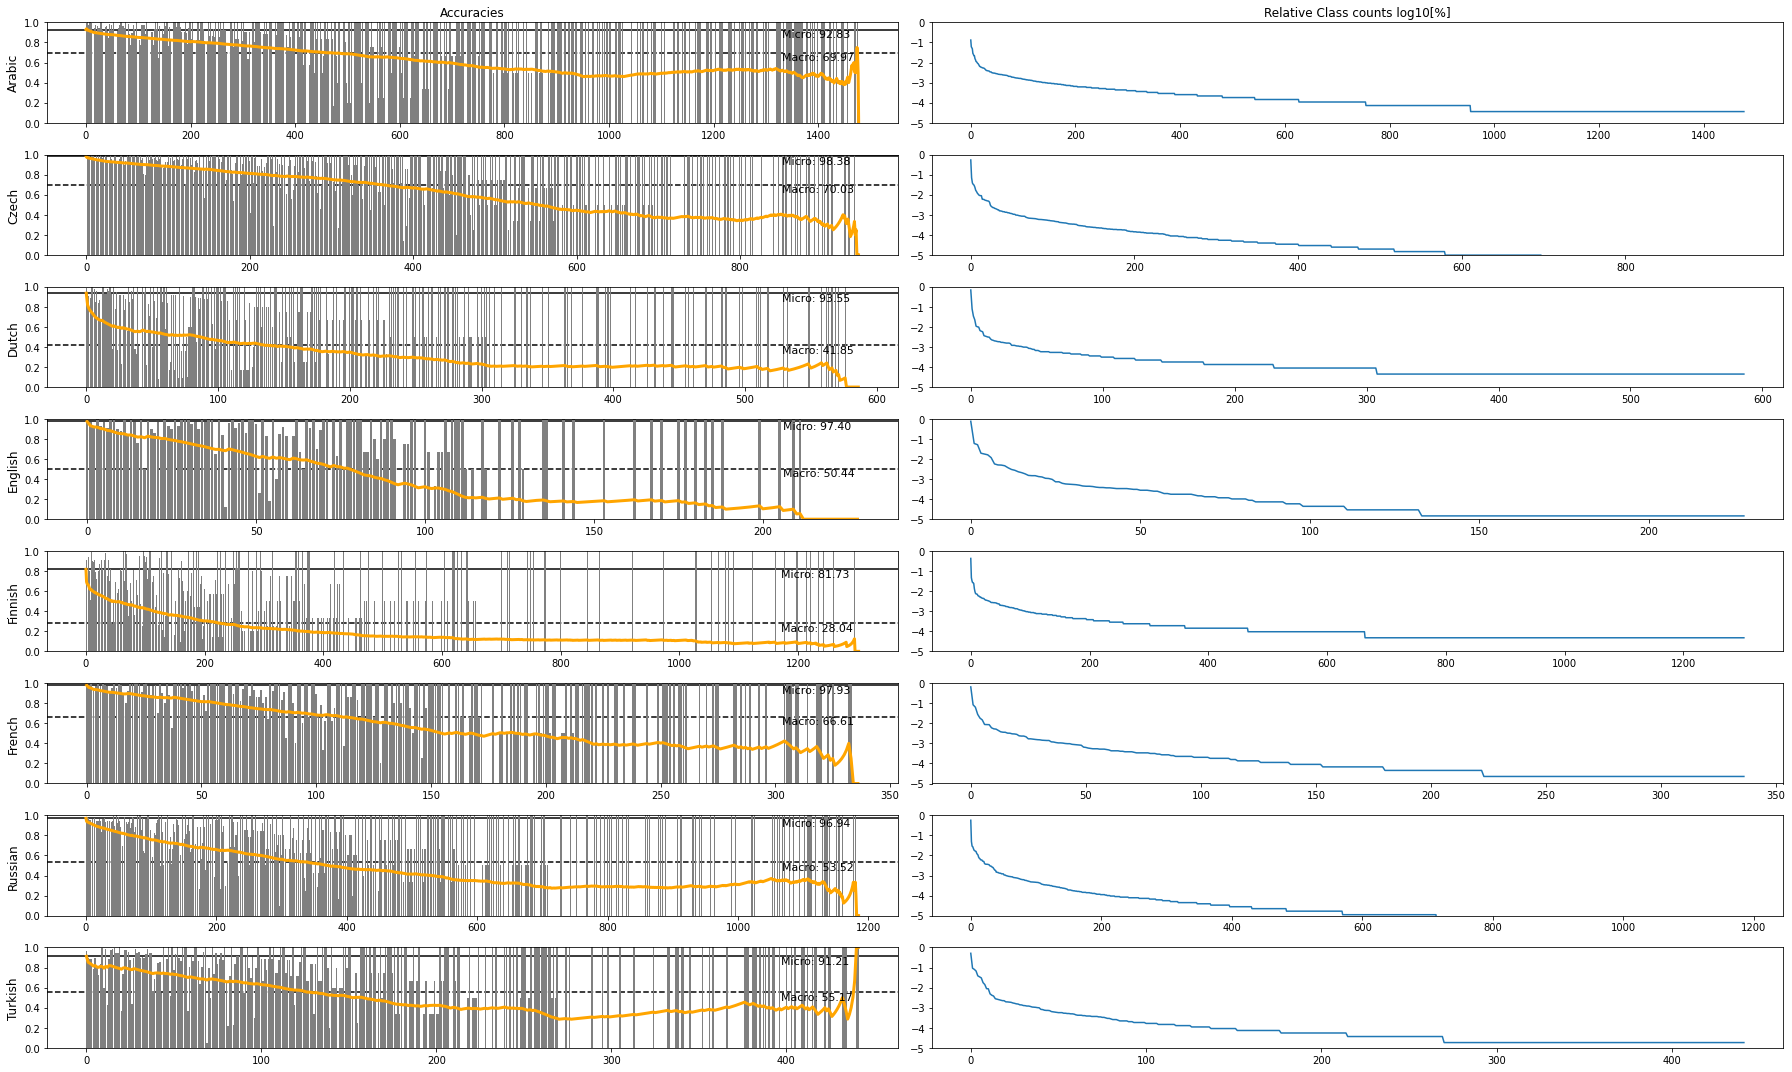

In [53]:
fig, axes = plt.subplots(ncols=2, nrows=N_langs, figsize=(25, 15))

for row, axes_row in enumerate(axes):

    acc_stats = defaultdict(RunningStats)
    for tok in eval_data[langs[row]]:
        acc_stats[tok[3]](int(tok[3] == tok[4]))
    acc_stats = dict(acc_stats)

    x, stats = list(map(list, zip(*sorted(acc_stats.items(), key=lambda x: x[1].N, reverse=True))))
    N, mean = np.array([s.N for s in stats]), np.array([s.mean for s in stats])

    micro_mean = np.sum(N * mean) / np.sum(N)
    macro_mean = np.mean(mean)

    for col, ax in enumerate(axes_row):

        if col == 0:
            # First column: accuracies

            # Barplot of accuracy per class
            ax.bar(np.arange(len(N)), mean, color='gray', zorder=0)

            # Plot micro-mean
            ax.axhline(y=micro_mean, c='black', ls='-', zorder=-1)
            ax.text(int(0.90 * len(N)), micro_mean-0.08, f'Micro: {micro_mean*100:.2f}', size=11, color='black')

            # Plot macro-mean
            ax.axhline(y=macro_mean, c='black', ls='--', zorder=-1)
            ax.text(int(0.90 * len(N)), macro_mean-0.08, f'Macro: {macro_mean*100:.2f}', size=11, color='black')

            # Plot micro-mean per excluded class
            micro_means = [np.sum(N[i:] * mean[i:]) / np.sum(N[i:]) for i in range(len(N))]
            ax.plot(micro_means, c='orange', zorder=1, linewidth=3)

            # Set titles and such
            if row == 0:
                ax.set_title("Accuracies", size=12)

            ax.set_ylabel(langs[row], size=12)

            ax.set_ylim(0.0, 1.0)

            lang_stats[langs[row]].update({
                "Lemma/Acc. Micro": micro_mean,
                "Lemma/Acc. Micro @ 2": micro_means[2],
                "Lemma/Acc. Micro @ 10": micro_means[10],
                "Lemma/Acc. Micro @ 100": micro_means[100],
                "Lemma/Acc. Macro": macro_mean,
            })

        if col == 1:
            # Second column: class occurence

            ax.plot(np.log10(N) - np.log10(np.sum(N)))

            if row == 0:
                ax.set_title("Relative Class counts log10[%]", size=12)

            ax.set_ylim(-5, 0)

    plt.tight_layout()

All languages perform poorly when lemma scripts become less frequent. The rate of decay, see gap between micro and macro averaged mean accuracies or the strength of the orange line, seems to be caused by the size of the training dataset and the complexity of the language (strongly correlated). Micro-averaged performance seems to be largely dominated by the most common classes, and in turn by the dataset size.

## Edit Distance

In [54]:
fig, axes = plt.subplots(nrows=N_langs, ncols=4, figsize=(25, 15))

for row, axes_row in enumerate(axes):

    dist_stats = []
    dist_stats_conditional = defaultdict(RunningStats)
    for tok in eval_data[langs[row]]:
        wf_to_lm = edit_distance(tok[0], tok[1])
        wf_to_out = edit_distance(tok[0], tok[2])
        lm_to_out = edit_distance(tok[1], tok[2])

        dist_stats.append([wf_to_lm, wf_to_out, wf_to_lm - wf_to_out, lm_to_out])
        dist_stats_conditional[tok[3]](lm_to_out)

    wf_to_lm, wf_to_out, wf_to_error, lm_to_out = list(map(list, zip(*dist_stats)))
    dist_stats_conditional = dict(dist_stats_conditional)

    for col, ax in enumerate(axes_row):

        if col == 0:
            ax.set_ylabel(langs[row], size=12)

            bins = np.linspace(0, np.max(wf_to_lm)+1, np.max(wf_to_lm)+2)

            ax.hist([wf_to_lm, wf_to_out], bins=bins, color=['gray', 'orange'])

            ax.set_xticks(bins[::2])
            ax.set_yscale("log")

            if row == 0:
                ax.set_title("Hist. Comparison WF to GT & WF to Pred", size=12)

        if col == 1:

            bins = np.linspace(np.min(wf_to_error), np.max(wf_to_error)+1, np.max(wf_to_error)-np.min(wf_to_error)+2)

            ax.hist(wf_to_error, bins=bins, color='gray')

            ax.set_xticks(bins[::2])
            ax.set_yscale("log")

            if row == 0:
                ax.set_title("Diff. WF to GT & WF to Pred", size=12)

        if col == 2:

            bins = np.linspace(0, np.max(lm_to_out)+1, np.max(lm_to_out)+2)

            ax.hist(lm_to_out, bins=bins, color='gray')

            # Plot mean
            mean = np.mean(lm_to_out)
            ax.axvline(x=mean, c='orange', ls='-', zorder=2)
            ax.text(mean+0.5, 10, f'Mean: {mean:.2f}', size=11, color='black')

            ax.set_xticks(bins)
            ax.set_yscale("log")

            if row == 0:
                ax.set_title("WF to GT & WF to Pred", size=12)

        if col == 3:

            x, stats = list(map(list, zip(*sorted(dist_stats_conditional.items(), key=lambda x: x[0]))))
            N, mean = np.array([s.N for s in stats]), np.array([s.mean for s in stats])

            micro_mean = np.sum(N * mean) / np.sum(N)
            macro_mean = np.mean(mean)

            # Barplot of accuracy per class
            ax.bar(np.arange(len(N)), mean, color='gray', zorder=0, alpha=0.5)

            # Plot micro-mean
            ax.axhline(y=micro_mean, c='black', ls='-', zorder=-1)
            ax.text(int(0.80 * len(N)), micro_mean-0.08, f'Micro: {micro_mean:.2f}', size=11, color='black')

            # Plot macro-mean
            ax.axhline(y=macro_mean, c='black', ls='--', zorder=-1)
            ax.text(int(0.80 * len(N)), macro_mean-0.08, f'Macro: {macro_mean:.2f}', size=11, color='black')

            # Plot micro-mean per excluded class
            ax.plot([np.sum(N[i:] * mean[i:]) / np.sum(N[i:]) for i in range(len(N))], c='orange', zorder=1, linewidth=3)

            # Set titles and such
            if row == 0:
                ax.set_title("GT to Pred, Conditional", size=12)

        lang_stats[langs[row]].update({
            "Lemma/Lev. Dist. Micro": micro_mean,
            "Lemma/Lev. Dist. Macro": macro_mean,
        })

plt.tight_layout()

### Vocab

In [ ]:
set_of_lemmas = defaultdict(set)
set_of_pred_lemmas = defaultdict(set)

for lang in langs:
    for tok in eval_data[lang]:
        set_of_lemmas[lang].update([tok[1].lower()])
        set_of_pred_lemmas[lang].update([tok[2].lower()])

    lang_stats[lang].update({
        "Lemma/Vocab Growth": (len(set_of_pred_lemmas[lang]) - len(set_of_lemmas[lang])) / len(set_of_lemmas[lang])
        })

## Lemmatization Summary

In [ ]:
df = pd.DataFrame.from_dict(lang_stats, orient="index")
df.columns = pd.MultiIndex.from_tuples([tuple(col_name.split("/")) for col_name in df.columns])

df

TypeError: Cannot infer number of levels from empty list

# Overall & Morphological Tagging

In [43]:
stats_df = pd.DataFrame.from_dict(eval_stats, orient="index")
stats_df = stats_df.drop(columns=["morph_tag_f1"])

morph_tag_f1 = []
for micro, macro in zip(stats_df["morph_tag_f1_micro"].values, stats_df["morph_tag_f1_macro"].values):
    morph_tag_f1.append(f"{micro}/{macro}")
stats_df["Morph. Tag F1"] = morph_tag_f1

stats_df.columns = [
    "Lemma Acc.",
    "Lev. Dist.",
    "Morph. Set Acc.",
    "a",
    "b",
    "Tokens/second",
    "Morph. Tag F1 (micro/macro)"
]

stats_df = stats_df.drop(columns=["a"])
stats_df = stats_df.drop(columns=["b"])

cols = stats_df.columns.tolist()
cols_order = cols[:-2] + [cols[-1]] + [cols[-2]]

stats_df[cols_order]

,Lemma Acc.,Lev. Dist.,Morph. Set Acc.,Morph. Tag F1 (micro/macro),Tokens/second
Arabic,0.93 +- 1.54e-03,0.21 +- 5.32e-03,0.90 +- 1.81e-03,0.96/0.85,2313.08
Czech,0.98 +- 2.78e-04,0.03 +- 6.10e-04,0.92 +- 5.82e-04,0.98/0.90,2930.30
Dutch,0.94 +- 1.60e-03,0.12 +- 3.83e-03,0.95 +- 1.51e-03,0.97/0.93,3222.71
English,0.97 +- 6.07e-04,0.05 +- 1.33e-03,0.92 +- 1.01e-03,0.96/0.90,2976.70
Finnish,0.82 +- 2.64e-03,0.44 +- 7.71e-03,0.81 +- 2.69e-03,0.92/0.62,2632.62
French,0.98 +- 6.72e-04,0.04 +- 1.63e-03,0.92 +- 1.25e-03,0.97/0.87,3715.83
Russian,0.97 +- 4.05e-04,0.06 +- 9.90e-04,0.92 +- 6.40e-04,0.97/0.88,2759.40
Turkish,0.91 +- 1.21e-03,0.19 +- 3.13e-03,0.77 +- 1.80e-03,0.89/0.58,1828.43


In [46]:
eval_stats["Turkish"]["morph_tag_f1"]

[('PST+PRF', 'F1: 0.00 (0.00/0.00), N: 1'),
 ('INFM', 'F1: 0.00 (0.00/0.00), N: 2'),
 ('EQTV', 'F1: 0.00 (0.00/0.00), N: 5'),
 ('RECP', 'F1: 0.00 (0.00/0.00), N: 6'),
 ('PSSS', 'F1: 0.00 (0.00/0.00), N: 10'),
 ('V.MSDR', 'F1: 0.00 (0.00/0.00), N: 26'),
 ('INTJ', 'F1: 0.00 (0.00/0.00), N: 52'),
 ('OPT', 'F1: 0.00 (0.00/0.00), N: 81'),
 ('V.CVB', 'F1: 0.00 (0.00/0.00), N: 81'),
 ('COND', 'F1: 0.00 (0.00/0.00), N: 85'),
 ('PSS2P', 'F1: 0.00 (0.00/0.00), N: 97'),
 ('PSS2S', 'F1: 0.00 (0.00/0.00), N: 290'),
 ('PSS3P', 'F1: 0.01 (0.40/0.01), N: 291'),
 ('PSS1P', 'F1: 0.01 (0.40/0.01), N: 220'),
 ('NFH', 'F1: 0.03 (0.28/0.06), N: 125'),
 ('CAUS', 'F1: 0.11 (0.81/0.07), N: 191'),
 ('IPFV', 'F1: 0.22 (0.71/0.16), N: 129'),
 ('POT', 'F1: 0.22 (0.94/0.13), N: 127'),
 ('INS', 'F1: 0.28 (0.82/0.17), N: 418'),
 ('PSS1S', 'F1: 0.38 (0.86/0.24), N: 469'),
 ('FUT', 'F1: 0.38 (0.79/0.25), N: 255'),
 ('FH', 'F1: 0.56 (0.44/0.75), N: 377'),
 ('NEG', 'F1: 0.59 (0.74/0.49), N: 717'),
 ('V.PTCP', 'F1: 0.61 (